# BCI Competition IV Dataset 2b: CNN vs GCN

In [31]:
import numpy as np
import mne
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load BCI Competition IV Dataset 2b (2-class motor imagery)

In [32]:
data_list = []
labels_list = []

train_files = sorted(glob.glob('BCI_2b/*T.gdf'))
print(f'Found {len(train_files)} training files')

for train_file in train_files:
    raw = mne.io.read_raw_gdf(train_file, preload=True, verbose=False)
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    
    mi_event_ids = {k: v for k, v in event_id.items() if k in ['769', '770']}
    
    if len(mi_event_ids) > 0:
        epochs = mne.Epochs(raw, events, event_id=mi_event_ids,
                           tmin=0, tmax=4, baseline=None, preload=True, verbose=False)
        
        data = epochs.get_data()
        labels = epochs.events[:, -1]
        label_mapping = {v: i for i, (k, v) in enumerate(sorted(mi_event_ids.items(), key=lambda x: x[1]))}
        labels = np.array([label_mapping[l] for l in labels])
        
        data_list.append(data)
        labels_list.append(labels)
        print(f'{train_file}: {data.shape[0]} epochs, {data.shape[1]} channels')

X = np.concatenate(data_list, axis=0)
y = np.concatenate(labels_list, axis=0)

print(f'\nTotal: {X.shape} - 2 classes (left/right hand)')
num_channels = X.shape[1]
num_timepoints = X.shape[2]

Found 27 training files
BCI_2b\B0101T.gdf: 120 epochs, 6 channels
BCI_2b\B0102T.gdf: 120 epochs, 6 channels
BCI_2b\B0103T.gdf: 160 epochs, 6 channels
BCI_2b\B0201T.gdf: 120 epochs, 6 channels
BCI_2b\B0202T.gdf: 120 epochs, 6 channels
BCI_2b\B0203T.gdf: 160 epochs, 6 channels
BCI_2b\B0301T.gdf: 120 epochs, 6 channels
BCI_2b\B0302T.gdf: 120 epochs, 6 channels
BCI_2b\B0303T.gdf: 160 epochs, 6 channels
BCI_2b\B0401T.gdf: 120 epochs, 6 channels
BCI_2b\B0402T.gdf: 140 epochs, 6 channels
BCI_2b\B0403T.gdf: 160 epochs, 6 channels
BCI_2b\B0501T.gdf: 120 epochs, 6 channels
BCI_2b\B0502T.gdf: 140 epochs, 6 channels
BCI_2b\B0503T.gdf: 160 epochs, 6 channels
BCI_2b\B0601T.gdf: 120 epochs, 6 channels
BCI_2b\B0602T.gdf: 120 epochs, 6 channels
BCI_2b\B0603T.gdf: 160 epochs, 6 channels
BCI_2b\B0701T.gdf: 120 epochs, 6 channels
BCI_2b\B0702T.gdf: 120 epochs, 6 channels
BCI_2b\B0703T.gdf: 160 epochs, 6 channels
BCI_2b\B0801T.gdf: 160 epochs, 6 channels
BCI_2b\B0802T.gdf: 120 epochs, 6 channels
BCI_2b\B08

## Prepare Data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, num_timepoints)).reshape(-1, num_channels, num_timepoints)
X_test = scaler.transform(X_test.reshape(-1, num_timepoints)).reshape(-1, num_channels, num_timepoints)

y_train_cat = keras.utils.to_categorical(y_train, 2)
y_test_cat = keras.utils.to_categorical(y_test, 2)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (2944, 6, 1001), Test: (736, 6, 1001)


## Compute Graph Structure

In [34]:
def compute_adjacency_from_pearson(data):
    n_epochs, n_channels, n_timepoints = data.shape
    data_reshaped = data.transpose(1, 0, 2).reshape(n_channels, -1)
    correlation_matrix = np.corrcoef(data_reshaped)
    adjacency = np.abs(correlation_matrix)
    np.fill_diagonal(adjacency, 1.0)
    return adjacency.astype(np.float32)

def compute_laplacian(adjacency):
    D = np.sum(adjacency, axis=1)
    D_sqrt_inv = np.diag(1.0 / np.sqrt(D + 1e-6))
    L = np.eye(len(adjacency)) - D_sqrt_inv @ adjacency @ D_sqrt_inv
    lambda_max = np.linalg.eigvalsh(L)[-1]
    L_rescaled = (2.0 / lambda_max) * L - np.eye(len(L))
    return L_rescaled.astype(np.float32)

adjacency = compute_adjacency_from_pearson(X_train)
L_rescaled = compute_laplacian(adjacency)
print(f'Adjacency: {adjacency.shape}, Laplacian: {L_rescaled.shape}')

Adjacency: (6, 6), Laplacian: (6, 6)


## Chebyshev Graph Convolution

In [35]:
class ChebyshevGraphConv(layers.Layer):
    def __init__(self, num_filters, K=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters = num_filters
        self.K = K

    def build(self, input_shape):
        self.theta = [self.add_weight(shape=(input_shape[0][-1], self.num_filters),
                                     initializer='glorot_uniform', name=f'theta_{k}')
                     for k in range(self.K)]
        super().build(input_shape)

    def call(self, inputs):
        x, L_rescaled = inputs
        Tx_0 = x
        Tx_1 = tf.matmul(L_rescaled, x)
        out = tf.matmul(Tx_0, self.theta[0])
        if self.K > 1:
            out += tf.matmul(Tx_1, self.theta[1])
        for k in range(2, self.K):
            Tx_2 = 2 * tf.matmul(L_rescaled, Tx_1) - Tx_0
            out += tf.matmul(Tx_2, self.theta[k])
            Tx_0, Tx_1 = Tx_1, Tx_2
        return out

## CNN Model

In [36]:
def create_cnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Permute((2, 1))(inputs)
    
    x = layers.Conv1D(64, 50, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv1D(128, 25, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv1D(256, 10, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn((num_channels, num_timepoints), 2)
print(f'CNN: {cnn_model.count_params():,} parameters')

CNN: 587,074 parameters


## GCN Model

In [37]:
def create_gcn(input_shape, num_classes, num_channels, L_rescaled):
    inputs = layers.Input(shape=input_shape)
    x = layers.Permute((2, 1))(inputs)
    
    x = layers.Conv1D(64, 50, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv1D(128, 25, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    cnn_features = x
    
    channel_input = layers.Input(shape=(num_channels, num_timepoints))
    channel_avg = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_input)
    
    L_tensor = tf.constant(L_rescaled, dtype=tf.float32)
    graph_features = ChebyshevGraphConv(64, K=2)([channel_avg, L_tensor])
    graph_features = layers.Flatten()(graph_features)
    
    combined = layers.Concatenate()([cnn_features, graph_features])
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model([inputs, channel_input], outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

gcn_model = create_gcn((num_channels, num_timepoints), 2, num_channels, L_rescaled)
print(f'GCN: {gcn_model.count_params():,} parameters')

GCN: 291,010 parameters


## Metrics Callback

In [38]:
cnn_metrics_callback = MetricsCallback()

cnn_history = cnn_model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[
        cnn_metrics_callback,
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', verbose=1)
    ],
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6200 - loss: 0.6771 - val_accuracy: 0.5993 - val_loss: 0.6389 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6548 - loss: 0.6165 - val_accuracy: 0.6265 - val_loss: 0.6460 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.6726 - loss: 0.5845 - val_accuracy: 0.6672 - val_loss: 0.6016 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6824 - loss: 0.5743 - val_accuracy: 0.6706 - val_loss: 0.5774 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7019 - loss: 0.5471 - val_accuracy: 0.6910 - val_loss: 0.5564 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7197 - loss: 0.5203 - val_accuracy: 0.5959 - val_loss: 0.6656 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7503 - loss: 0.4943 - val_accuracy: 

## Train CNN

In [39]:
gcn_metrics_callback = MetricsCallback()

gcn_history = gcn_model.fit(
    [X_train, X_train], y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[
        gcn_metrics_callback,
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', verbose=1)
    ],
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5928 - loss: 0.6549 - val_accuracy: 0.6333 - val_loss: 0.6202 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6471 - loss: 0.6094 - val_accuracy: 0.6486 - val_loss: 0.6135 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 868ms/step - accuracy: 0.6586 - loss: 0.5980 - val_accuracy: 0.6078 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 982ms/step - accuracy: 0.6845 - loss: 0.5727 - val_accuracy: 0.6112 - val_loss: 0.6225 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 950ms/step - accuracy: 0.7146 - loss: 0.5433 - val_accuracy: 0.7097 - val_loss: 0.5469 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7223 - loss: 0.5206 - val_accuracy: 0.6995 - val_loss: 0.5570 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7321 - loss: 0.5139 - val_a

## Visualizations

FINAL RESULTS
CNN Accuracy: 78.80%
GCN Accuracy: 76.90%
WINNER: CNN (+1.90%)


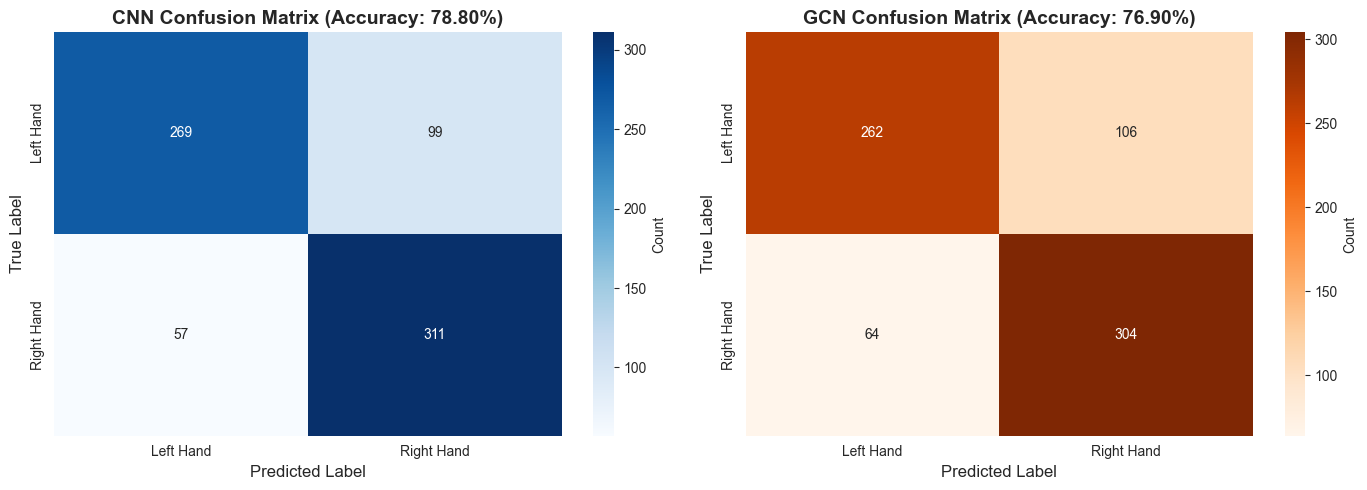


CNN Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.83      0.73      0.78       368
  Right Hand       0.76      0.85      0.80       368

    accuracy                           0.79       736
   macro avg       0.79      0.79      0.79       736
weighted avg       0.79      0.79      0.79       736


GCN Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.80      0.71      0.76       368
  Right Hand       0.74      0.83      0.78       368

    accuracy                           0.77       736
   macro avg       0.77      0.77      0.77       736
weighted avg       0.77      0.77      0.77       736



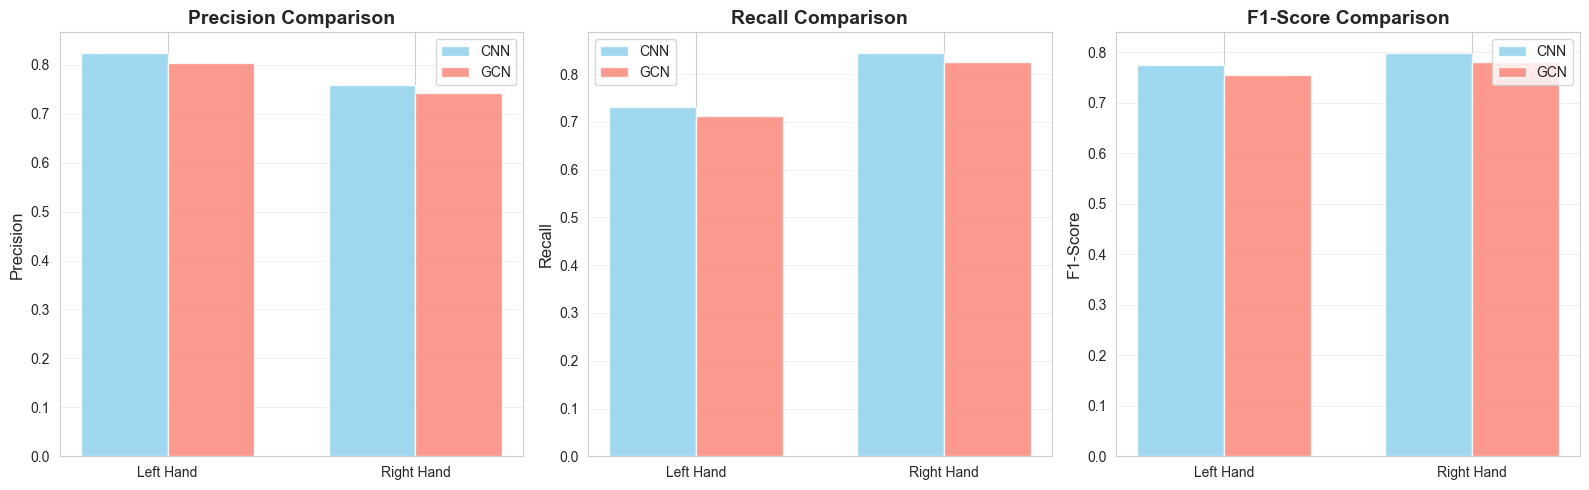


MODEL COMPARISON SUMMARY
       Metric     CNN     GCN
Test Accuracy  78.80%  76.90%
    Test Loss  0.4614  0.4490
   Parameters 587,074 291,010
Avg Precision  0.7918  0.7726
   Avg Recall  0.7880  0.7690
 Avg F1-Score  0.7874  0.7683


In [40]:
cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test_cat, verbose=0)
gcn_loss, gcn_acc = gcn_model.evaluate([X_test, X_test], y_test_cat, verbose=0)

cnn_preds = cnn_model.predict(X_test, verbose=0)
gcn_preds = gcn_model.predict([X_test, X_test], verbose=0)

cnn_pred_classes = np.argmax(cnn_preds, axis=1)
gcn_pred_classes = np.argmax(gcn_preds, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

class_names = ['Left Hand', 'Right Hand']

print('='*70)
print('FINAL RESULTS')
print('='*70)
print(f'CNN Accuracy: {cnn_acc*100:.2f}%')
print(f'GCN Accuracy: {gcn_acc*100:.2f}%')
print('='*70)

if gcn_acc > cnn_acc:
    print(f'WINNER: GCN (+{(gcn_acc-cnn_acc)*100:.2f}%)')
else:
    print(f'WINNER: CNN (+{(cnn_acc-gcn_acc)*100:.2f}%)')

cnn_cm = confusion_matrix(y_test_classes, cnn_pred_classes)
gcn_cm = confusion_matrix(y_test_classes, gcn_pred_classes)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
            yticklabels=class_names, ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'CNN Confusion Matrix (Accuracy: {cnn_acc*100:.2f}%)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

sns.heatmap(gcn_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, 
            yticklabels=class_names, ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'GCN Confusion Matrix (Accuracy: {gcn_acc*100:.2f}%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\nCNN Classification Report:")
print(classification_report(y_test_classes, cnn_pred_classes, target_names=class_names))
print("\nGCN Classification Report:")
print(classification_report(y_test_classes, gcn_pred_classes, target_names=class_names))

cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(y_test_classes, cnn_pred_classes, average=None)
gcn_precision, gcn_recall, gcn_f1, _ = precision_recall_fscore_support(y_test_classes, gcn_pred_classes, average=None)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
x = np.arange(len(class_names))
width = 0.35

axes[0].bar(x - width/2, cnn_precision, width, label='CNN', color='skyblue', alpha=0.8)
axes[0].bar(x + width/2, gcn_precision, width, label='GCN', color='salmon', alpha=0.8)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(x - width/2, cnn_recall, width, label='CNN', color='skyblue', alpha=0.8)
axes[1].bar(x + width/2, gcn_recall, width, label='GCN', color='salmon', alpha=0.8)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_title('Recall Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(x - width/2, cnn_f1, width, label='CNN', color='skyblue', alpha=0.8)
axes[2].bar(x + width/2, gcn_f1, width, label='GCN', color='salmon', alpha=0.8)
axes[2].set_ylabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(class_names)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

summary_data = {
    'Metric': ['Test Accuracy', 'Test Loss', 'Parameters', 'Avg Precision', 'Avg Recall', 'Avg F1-Score'],
    'CNN': [
        f'{cnn_acc*100:.2f}%',
        f'{cnn_loss:.4f}',
        f'{cnn_model.count_params():,}',
        f'{np.mean(cnn_precision):.4f}',
        f'{np.mean(cnn_recall):.4f}',
        f'{np.mean(cnn_f1):.4f}'
    ],
    'GCN': [
        f'{gcn_acc*100:.2f}%',
        f'{gcn_loss:.4f}',
        f'{gcn_model.count_params():,}',
        f'{np.mean(gcn_precision):.4f}',
        f'{np.mean(gcn_recall):.4f}',
        f'{np.mean(gcn_f1):.4f}'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)